In [27]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

print(tf.__version__)

1.10.0


##### The Boston Housing Prices dataset

In [28]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

In [29]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


* Each one of these input data features is stored using a different scale. 
* Some features are represented by a proportion between 0 and 1
* other features are ranges between 1 and 12, 
* some are ranges between 0 and 100, and so on. 
* This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

In [30]:
print(train_data[0])  # Display sample features, notice the different scales

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


In [31]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(train_data, columns=column_names)
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
0  0.07875  45.0   3.44   0.0  0.437  6.782  41.1  3.7886   5.0  398.0   
1  4.55587   0.0  18.10   0.0  0.718  3.561  87.9  1.6132  24.0  666.0   
2  0.09604  40.0   6.41   0.0  0.447  6.854  42.8  4.2673   4.0  254.0   
3  0.01870  85.0   4.15   0.0  0.429  6.516  27.7  8.5353   4.0  351.0   
4  0.52693   0.0   6.20   0.0  0.504  8.725  83.0  2.8944   8.0  307.0   

   PTRATIO       B  LSTAT  
0     15.2  393.87   6.68  
1     20.2  354.70   7.12  
2     17.6  396.90   2.98  
3     17.9  392.43   6.36  
4     17.4  382.00   4.63

##### Labels
The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [32]:
print(train_labels[0:10])  # Display first 10 entries

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


##### Normalize features

* It's recommended to normalize features that use different scales and ranges. 
* For each feature, subtract the mean of the feature and divide by the standard deviation:

In [33]:
print(train_data[0])

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


In [34]:
# Test data is *not* used when calculating the mean and std.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


##### Create the model
* Use a Sequential model with two densely connected hidden layers, 
* An output layer that returns a single, continuous value. 
* The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [35]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


##### Train the model
The model is trained for 500 epochs, and record the training and validation accuracy in the history object.

In [36]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

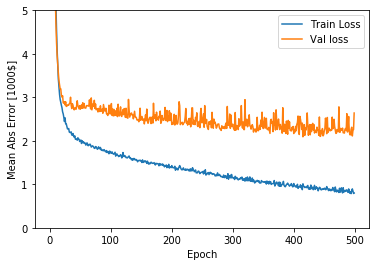

In [37]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)


....................................................................................................
.............................................................................................

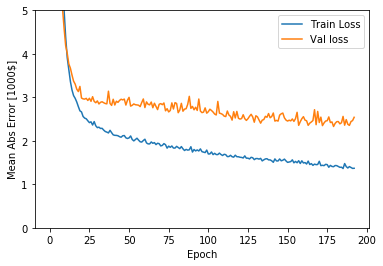

In [38]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)


* The graph shows the average error is about 2.5K dollars. 
* 2.5K is significant amount when some of the labels are 15K

In [22]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2661.57


###### Predict

In [25]:
test_predictions = model.predict(test_data).flatten()

print(test_predictions)

[ 8.7861395 19.521877  21.484024  32.554497  26.09831   22.476583
 25.753355  22.260319  19.111412  22.094631  19.902445  16.984442
 15.856211  42.399406  19.525755  20.606627  27.36509   18.679804
 19.463648  28.06991   11.759682  14.818216  21.397284  17.958021
 20.65034   26.739504  29.930984  29.154999  11.400788  20.845165
 20.266922  15.544226  32.122936  25.723093  17.780794   8.16106
 17.462442  16.961126  19.669992  25.746786  30.329412  27.96479
 13.894918  42.705284  31.059303  25.780825  28.223684  17.366875
 23.099459  22.502026  35.299694  21.142017  10.954527  15.089361
 35.290848  28.778982  12.681838  49.317974  33.192574  25.097876
 25.19509   15.942118  14.7588005 20.307276  23.544092  20.594053
 13.312883  23.139805  12.6587105  7.516791  27.47136   30.13183
 27.67095   13.289612  25.83378   19.1938    20.20812   23.98754
 35.73787   10.045632  21.446062  37.56558   17.403257  13.652556
 17.935232  18.875427  20.187973  20.77766   20.702398  32.92792
 21.627348  19.

##### Conclusions

* Classification and Regression problems must be attacked differently. Common loss function used for regression 
* Mean Squared Error (MSE)
* Mean Absolute Error (MAE)
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.